In [1]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LambdaCallback
from keras.callbacks import EarlyStopping, TensorBoard
import argparse
import midi
import os

from constants import *
from dataset import load_all
from generate import write_file, generate
from play_music_util import play_music

import pygame
import base64

from playsound import playsound

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, LSTM, Dense, Dropout, Lambda, Reshape, Permute
from keras.layers import TimeDistributed, RepeatVector, Conv1D, Activation
from keras.layers import Embedding, Flatten, dot, concatenate 
from keras.layers.merge import Concatenate, Add, Multiply
from keras.models import Model
import keras.backend as K
from keras import losses
from keras.utils import multi_gpu_model

In [3]:
styles[0]
# styles[0] = 'data/test'
# styles[0] 

['data/test']

In [4]:
print('Loading data')
train_data, train_labels = load_all(styles, BATCH_SIZE, SEQ_LEN)

Loading data


In [5]:
train_data[0].shape

(10, 128, 48, 3)

In [6]:
for i in range(3):
    print(train_data[i].shape)

(10, 128, 48, 3)
(10, 128, 48, 3)
(10, 128, 16)


In [7]:
# train_labels[0].shape

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
 BATCH_SIZE, NUM_NOTES, NOTE_UNITS

(32, 48, 3)

In [10]:
cuda = False

def iterate_minibatches(train_data, train_labels, batchsize):
    indices = np.random.permutation(np.arange(len(train_labels)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        
        if cuda:      
            yield  Variable(torch.FloatTensor(train_data[ix])).cuda(), Variable(torch.FloatTensor(train_labels[ix])).cuda()
        else:
            yield Variable(torch.FloatTensor(train_data[ix])), Variable(torch.FloatTensor(train_labels[ix]))

#  Pytorch implementation

In [11]:
class time_axis(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__() 
        self.n_layers = 1
        self.hidden_size = TIME_AXIS_UNITS
        self.input_size = NOTE_UNITS
        

        self.time_lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, dropout=0.1, 
                                 batch_first=True, )
        self.dropout = nn.Dropout(p=0.2, inplace=True)
        
    def forward(self, notes):
        
        """
        arg:
            notes - (batch, time_seq, note_seq, note_features)
        
        out: 
            (batch, time_seq, note_seq, hidden_features)
            
        """
        
        lstm_out = []        
        for i in range(notes.shape[2]):
            
            out, hidden = self.time_lstm(notes[:, :, i,:]) 
            
            lstm_out.append(out[:, :, None, :])

        
        
        time_output = torch.cat(lstm_out, dim=2)
#         self.dropout(time_output)
        
        return time_output        
    
class note_axis(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()   
        
        self.n_layers = 2
        self.hidden_size = NOTE_AXIS_UNITS
        # number of time features plus number of previous higher note in the same time momemt
        self.input_size = TIME_AXIS_UNITS + NOTE_UNITS
        
        # maybe it is better to make two lstm and make the second one bideractional 
        self.note_lstm = nn.LSTM(self.input_size, self.hidden_size, self.n_layers, dropout=0.1, 
                                 batch_first=True, )
        
        self.dropout = nn.Dropout(p=0.2, inplace=True)
        
        self.logits = nn.Linear(self.hidden_size, NOTE_UNITS) 
        
    def forward(self, notes, chosen):
        """
        arg:
            notes - (batch, time_seq, note_seq, time_hidden_features)
        
        out: 
            (batch, time_seq, note_seq, next_notes_features)
            
        """
                
        # Shift target one note to the left.
        shift_chosen = nn.ZeroPad2d((0, 0, 1, 0))(chosen[:, :, :-1, :])            
        note_input = torch.cat([notes, shift_chosen], dim=-1)

        
        lstm_out = []
        for i in range(notes.shape[1]):
            
            out, hidden = self.note_lstm(note_input[:, i, :,:]) 
            lstm_out.append(out[:, None, :, :])
              
        time_output = torch.cat(lstm_out, dim=1)
#         self.dropout(time_output)

        logits = self.logits(time_output) 
        next_notes = nn.Sigmoid()(logits)
        
        return next_notes 
    
class Generator(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()        
        
        self.time_ax = time_axis() 
        self.note_ax = note_axis()
        
    def forward(self, notes, chosen):
        
        note_ax_output = self.time_ax(notes)
        output = self.note_ax(note_ax_output, chosen)
        
        return output   

In [12]:
criterion_bce_play = nn.BCELoss()  
criterion_bce_replay = nn.BCELoss() 
criterion_mse = nn.MSELoss()  

def compute_loss(y_pred, y_true):
    
    played = y_true[:, :, :, 0]
    
    bce_note = criterion_bce_play(y_pred[:, :, :, 0], y_true[:, :, :, 0])

    replay = played*y_pred[:, :, :, 1] + (1 - played)*y_true[:, :, :, 1]
    
    bce_replay = criterion_bce_replay(replay, y_true[:, :, :, 1])
    
    volume = played*y_pred[:, :, :, 2] + (1 - played)*y_true[:, :, :, 2]
    mse = criterion_mse(volume, y_true[:, :, :, 2] )
    
    return bce_note + bce_replay + mse


In [36]:
compute_loss(output, chosen)

Variable containing:
 0.6974
[torch.FloatTensor of size 1]

In [37]:
generator = Generator()

In [38]:
train_data[0].shape

(10, 128, 48, 3)

In [39]:
X_tr = train_data[0][:-1]
X_te = train_data[0][-1:]
y_tr = train_labels[0][:-1]
y_te = train_labels[0][-1:]

In [40]:
X_tr.shape, X_te.shape

((9, 128, 48, 3), (1, 128, 48, 3))

In [42]:
import math
import time
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

Epoch 3 of 3 took 76.842s
current train loss: 0.3965347210566203
current val loss: 0.23487414419651031


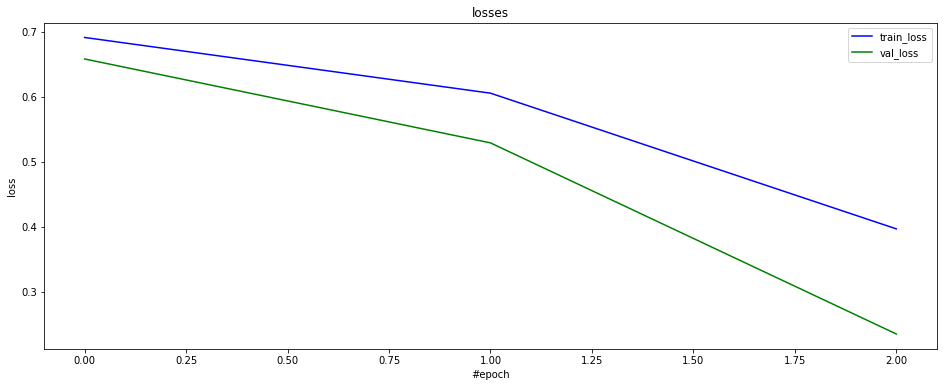

Finished!


In [43]:
from tqdm import tqdm
from torch import optim

def train(X_tr, X_te, y_tr, y_te, batchsize=3, n_epochs = 3):
    
    n_epochs = 3
    batchsize = 3
    optimizer = optim.Adam(generator.parameters())
    n_train_batches = math.ceil(len(X_tr)/batchsize)
    n_validation_batches = math.ceil(len(X_te)/batchsize)

    epoch_history = {'train_loss':[], 'val_loss':[]}

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = 0
        generator.train(True)    
        for X, y in tqdm(iterate_minibatches(X_tr, y_tr, batchsize)):

            optimizer.zero_grad()

            pred = generator(X, y)
            loss = compute_loss(pred, y)        
            loss.backward()

            optimizer.step()

            train_loss += loss.cpu().data.numpy()[0]

        train_loss /= n_train_batches
        epoch_history['train_loss'].append(train_loss)
    #     print('train_loss', train_loss)

        generator.train(False)
        val_loss = 0
        for X, y in tqdm(iterate_minibatches(X_te, y_te, batchsize)):
            pred = generator(X, y)
            loss = compute_loss(pred, y) 

            val_loss += loss.cpu().data.numpy()[0]

        val_loss /= n_validation_batches
        epoch_history['val_loss'].append(val_loss)
    #     print('val_loss', val_loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time)) 
        print('current train loss: {}'.format(epoch_history['train_loss'][-1]))
        print('current val loss: {}'.format(epoch_history['val_loss'][-1]))

        plt.title("losses")
        plt.xlabel("#epoch")
        plt.ylabel("loss")
        plt.plot(epoch_history['train_loss'], 'b', label = 'train_loss')
        plt.plot(epoch_history['val_loss'], 'g', label = 'val_loss')
        plt.legend()
        plt.show()

    print("Finished!")
    
    return epoch_history

In [142]:
generator.time_ax, generator.note_ax

(time_axis(
   (time_lstm): LSTM(3, 256, batch_first=True, dropout=0.1)
   (dropout): Dropout(p=0.2, inplace)
 ), note_axis(
   (note_lstm): LSTM(259, 128, num_layers=2, batch_first=True, dropout=0.1)
   (dropout): Dropout(p=0.2, inplace)
   (logits): Linear(in_features=128, out_features=3)
 ))

In [145]:
generator.train(False) 

Generator(
  (time_ax): time_axis(
    (time_lstm): LSTM(3, 256, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.2, inplace)
  )
  (note_ax): note_axis(
    (note_lstm): LSTM(259, 128, num_layers=2, batch_first=True, dropout=0.1)
    (dropout): Dropout(p=0.2, inplace)
    (logits): Linear(in_features=128, out_features=3)
  )
)

In [13]:
# torch.save(generator.state_dict(), os.path.join(OUT_DIR, 'model_canonical'))
the_model = Generator()
the_model.load_state_dict(torch.load(os.path.join(OUT_DIR, 'model_canonical')))

In [15]:
dummy_note = Variable(torch.Tensor(train_data[0]))
chosen = Variable(torch.Tensor(train_data[1]))

# output = generator.forward(dummy_note, chosen)
output = the_model.forward(dummy_note, chosen)

print('dummy_time_features :', output.shape)
output[0][0][3], output2[0][0][3]

dummy_time_features : torch.Size([10, 128, 48, 3])


(Variable containing:
  0.4009
  0.4684
  0.5171
 [torch.FloatTensor of size 3], Variable containing:
  0.4034
  0.4694
  0.5169
 [torch.FloatTensor of size 3])

# Canonical

In [62]:
write_file('output/canonical_test', generate(the_model, 4))

  0%|          | 0/64 [00:00<?, ?it/s]

Generating with no styles:
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.S

  2%|▏         | 1/64 [00:01<01:37,  1.55s/it]

ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predicti

  3%|▎         | 2/64 [00:03<01:41,  1.64s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

  5%|▍         | 3/64 [00:04<01:37,  1.59s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

  6%|▋         | 4/64 [00:06<01:34,  1.58s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

  8%|▊         | 5/64 [00:08<01:34,  1.60s/it]

 torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Si

  9%|▉         | 6/64 [00:13<02:09,  2.23s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_n

 11%|█         | 7/64 [00:14<01:59,  2.09s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 12%|█▎        | 8/64 [00:15<01:51,  1.98s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 14%|█▍        | 9/64 [00:17<01:44,  1.90s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 16%|█▌        | 10/64 [00:18<01:39,  1.85s/it]

predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 17%|█▋        | 11/64 [00:20<01:36,  1.83s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 19%|█▉        | 12/64 [00:21<01:33,  1.80s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 20%|██        | 13/64 [00:23<01:31,  1.78s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 22%|██▏       | 14/64 [00:24<01:28,  1.78s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 23%|██▎       | 15/64 [00:26<01:25,  1.75s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 25%|██▌       | 16/64 [00:27<01:22,  1.72s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_n

 27%|██▋       | 17/64 [00:28<01:19,  1.69s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torc

 28%|██▊       | 18/64 [00:29<01:16,  1.66s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_n

 30%|██▉       | 19/64 [00:31<01:13,  1.64s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_n

 31%|███▏      | 20/64 [00:32<01:11,  1.62s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torc

 33%|███▎      | 21/64 [00:33<01:08,  1.60s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torc

 34%|███▍      | 22/64 [00:34<01:06,  1.58s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_n

 36%|███▌      | 23/64 [00:36<01:04,  1.57s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torc

 38%|███▊      | 24/64 [00:37<01:02,  1.55s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torc

 39%|███▉      | 25/64 [00:38<01:00,  1.54s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torc

 41%|████      | 26/64 [00:39<00:58,  1.53s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torc

 42%|████▏     | 27/64 [00:41<00:56,  1.52s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 44%|████▍     | 28/64 [00:42<00:54,  1.51s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_n

 45%|████▌     | 29/64 [00:43<00:52,  1.51s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 47%|████▋     | 30/64 [00:45<00:51,  1.51s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 48%|████▊     | 31/64 [00:46<00:49,  1.51s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 50%|█████     | 32/64 [00:48<00:48,  1.52s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 52%|█████▏    | 33/64 [00:50<00:47,  1.52s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 53%|█████▎    | 34/64 [00:51<00:45,  1.52s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 55%|█████▍    | 35/64 [00:53<00:44,  1.52s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 56%|█████▋    | 36/64 [00:54<00:42,  1.52s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 58%|█████▊    | 37/64 [00:56<00:41,  1.53s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 59%|█████▉    | 38/64 [00:57<00:39,  1.52s/it]

predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 61%|██████    | 39/64 [00:59<00:38,  1.52s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 62%|██████▎   | 40/64 [01:00<00:36,  1.51s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 64%|██████▍   | 41/64 [01:01<00:34,  1.51s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torc

 66%|██████▌   | 42/64 [01:03<00:33,  1.50s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 67%|██████▋   | 43/64 [01:04<00:31,  1.50s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 69%|██████▉   | 44/64 [01:05<00:29,  1.49s/it]

 torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128

 70%|███████   | 45/64 [01:07<00:28,  1.49s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 72%|███████▏  | 46/64 [01:08<00:26,  1.48s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 73%|███████▎  | 47/64 [01:09<00:25,  1.48s/it]

 torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_not

 75%|███████▌  | 48/64 [01:10<00:23,  1.48s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

 77%|███████▋  | 49/64 [01:12<00:22,  1.48s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 78%|███████▊  | 50/64 [01:13<00:20,  1.48s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 80%|███████▉  | 51/64 [01:15<00:19,  1.48s/it]

predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 81%|████████▏ | 52/64 [01:17<00:17,  1.48s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 83%|████████▎ | 53/64 [01:18<00:16,  1.48s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 84%|████████▍ | 54/64 [01:20<00:14,  1.48s/it]

predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 86%|████████▌ | 55/64 [01:21<00:13,  1.49s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 88%|████████▊ | 56/64 [01:23<00:11,  1.49s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 89%|████████▉ | 57/64 [01:25<00:10,  1.49s/it]

 torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Si

 91%|█████████ | 58/64 [01:26<00:08,  1.50s/it]

current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predicti

 92%|█████████▏| 59/64 [01:28<00:07,  1.50s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 94%|█████████▍| 60/64 [01:30<00:06,  1.50s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 95%|█████████▌| 61/64 [01:31<00:04,  1.50s/it]

predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 97%|█████████▋| 62/64 [01:33<00:03,  1.50s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

 98%|█████████▊| 63/64 [01:34<00:01,  1.50s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
ins (1, 128, 48, 3)
note_features torch.Size([1, 128, 48, 256])
note_features torch.Size([1, 1, 48, 256])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_n

100%|██████████| 64/64 [01:36<00:00,  1.50s/it]

predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])
predictions torch.Size([1, 1, 48, 3])
current_note torch.Size([1, 1, 48, 3])

In [63]:
midi_file = 'out/samples/output/canonical_test_0.mid'
play_music(midi_file)

Music file out/samples/output/canonical_test_0.mid loaded!
